In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision

from models import Classifier,ResNet_AutoEncoder

from diffusers import DDPMScheduler, UNet2DConditionModel

from clip import clip

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
#Loading the trained AE parameters
autoencoder = ResNet_AutoEncoder().to(device)
autoencoder.load_state_dict(torch.load("parameters/resnetae.pth", weights_only=True))

<All keys matched successfully>

In [14]:
#Loadinf UNet2DConditionModel and trained parameters
unet = UNet2DConditionModel(
        sample_size=14,          
        in_channels=1,            
        out_channels=1,
        layers_per_block=4,
        block_out_channels=(32, 64),
        cross_attention_dim= 512,
        down_block_types=( 
            "DownBlock2D",  
            "AttnDownBlock2D",
        ), 
        up_block_types=(       
            "AttnUpBlock2D",
            "UpBlock2D",
        ),
    ).to(device)
unet.load_state_dict(torch.load("parameters/unet2d.pth", weights_only=True))
noise_scheduler = DDPMScheduler(num_train_timesteps=1000,prediction_type="epsilon")

In [15]:
# Loading the Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
])
train_dataset = datasets.FashionMNIST(root='./data', train=True,
                                 transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [53]:
#Loading CLIP for text embeddings
clip_model, preprocess = clip.load("ViT-B/32")

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']
class_prompts = [f"a photo of a {class_name}" for class_name in class_names]

text_tokens = clip.tokenize(class_prompts).to(device)

# Encode the tokenized text using the text encoder
with torch.no_grad():
    precomputed_text_embeddings = clip_model.encode_text(text_tokens).to(torch.float32)

In [90]:
prompt = "A photo"

In [91]:
num_samples = 16

sample = torch.randn(num_samples, 1, 14, 14).to(device)
text_token = clip.tokenize(prompt).to(device)
with torch.no_grad():
    text_embedding = clip_model.encode_text(text_token).to(torch.float32).repeat(num_samples,1).unsqueeze(1)
    for i,t in tqdm(enumerate(noise_scheduler.timesteps)):
        output = unet(sample, t, text_embedding).sample
        sample = noise_scheduler.step(output, t, sample).prev_sample
    unnormalized_latents = (sample*2.8561)-1.2078
    images = autoencoder.decoder(unnormalized_latents)

1000it [00:24, 41.18it/s]


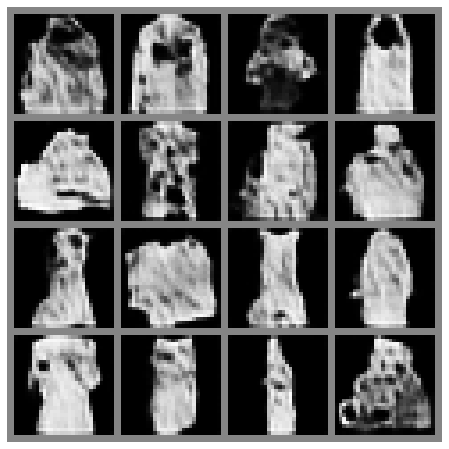

In [92]:
grid = torchvision.utils.make_grid(images, nrow=4, padding=2)

plt.figure(figsize=(8, 8))
plt.imshow(grid[0].cpu(),cmap="gray")
plt.axis('off')
plt.show()

In [9]:
sample = torch.randn(1, 14, 14)

In [35]:
example_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
a = iter(example_loader)


(-0.5, 13.5, 13.5, -0.5)

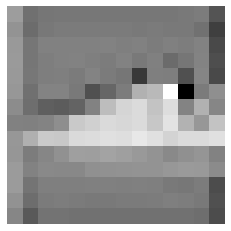

In [42]:
image = next(a)[0]
latent = autoencoder.encoder(image.to(device))
plt.imshow(latent[0,0].cpu().detach(),cmap="gray")
plt.axis("off")

(-0.5, 27.5, 27.5, -0.5)

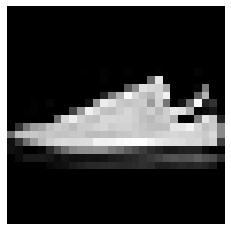

In [43]:
plt.imshow(image[0,0].cpu().detach(),cmap="gray")
plt.axis("off")